Amazon Case Study:

Maintenance cost reduction through predictive techniques

BACKGROUND

A company has a ﬂeet of devices transmitting daily telemetry readings. They would like to create a predictive maintenance solution to proactively identify when maintenance should be performed. This approach promises cost savings over routine or time-based preventive maintenance, because tasks are performed only when warranted. 

GOAL

You are tasked with building a predictive model using machine learning to predict the probability of a device failure. When building this model, be sure to minimize false positives and false negatives. The column you are trying to predict is called failure with binary value 0 for non-failure and 1 for failure.

DATA

Download link:  http://aws-proserve-data-science.s3.amazonaws.com/predictive_maintenance.csv 


In [0]:
# Importing required libraries & files

In [0]:
import dateutil
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, recall_score, precision_score, roc_auc_score, roc_curve
from time import sleep
import itertools

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from warnings import filterwarnings
filterwarnings('ignore')

In [0]:
# mounting google drive

In [0]:
from google.colab import drive

In [6]:
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
#----------------- Data loading------------------------#

In [0]:
df = pd.read_csv('/content/drive/My Drive/predictive_maintenance.csv')

In [9]:
df.head()

,date,device,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric8,metric9
0,1/1/15,S1F01085,0,215630672,56,0,52,6,407438,0,0,7
1,1/1/15,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0
2,1/1/15,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0
3,1/1/15,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,0
4,1/1/15,S1F01R2B,0,135970480,0,0,0,15,313173,0,0,3


# Exploratory Data Analysis

In [10]:
print(df.shape)

(124494, 12)


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124494 entries, 0 to 124493
Data columns (total 12 columns):
date       124494 non-null object
device     124494 non-null object
failure    124494 non-null int64
metric1    124494 non-null int64
metric2    124494 non-null int64
metric3    124494 non-null int64
metric4    124494 non-null int64
metric5    124494 non-null int64
metric6    124494 non-null int64
metric7    124494 non-null int64
metric8    124494 non-null int64
metric9    124494 non-null int64
dtypes: int64(10), object(2)
memory usage: 11.4+ MB


In [12]:
df.describe()

,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric8,metric9
count,124494.000000,1.244940e+05,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000
mean,0.000851,1.223881e+08,159.484762,9.940455,1.741120,14.222669,260172.657726,0.292528,0.292528,12.451524
std,0.029167,7.045933e+07,2179.657730,185.747321,22.908507,15.943028,99151.078547,7.436924,7.436924,191.425623
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000,1.000000,8.000000,0.000000,0.000000,0.000000
25%,0.000000,6.128476e+07,0.000000,0.000000,0.000000,8.000000,221452.000000,0.000000,0.000000,0.000000
50%,0.000000,1.227974e+08,0.000000,0.000000,0.000000,10.000000,249799.500000,0.000000,0.000000,0.000000
75%,0.000000,1.833096e+08,0.000000,0.000000,0.000000,12.000000,310266.000000,0.000000,0.000000,0.000000
max,1.000000,2.441405e+08,64968.000000,24929.000000,1666.000000,98.000000,689161.000000,832.000000,832.000000,18701.000000


In [13]:
# Checking for missing values
df.isnull().sum()

date       0
device     0
failure    0
metric1    0
metric2    0
metric3    0
metric4    0
metric5    0
metric6    0
metric7    0
metric8    0
metric9    0
dtype: int64

There is no missing values in the dataset

In [14]:
df.count()

date       124494
device     124494
failure    124494
metric1    124494
metric2    124494
metric3    124494
metric4    124494
metric5    124494
metric6    124494
metric7    124494
metric8    124494
metric9    124494
dtype: int64

In [15]:
# Checking for duplicate observations
df.duplicated().sum()

1

In [16]:
# Deleting the duplicate record
df = df.drop_duplicates()
df.count()

date       124493
device     124493
failure    124493
metric1    124493
metric2    124493
metric3    124493
metric4    124493
metric5    124493
metric6    124493
metric7    124493
metric8    124493
metric9    124493
dtype: int64

In [17]:
#imbalanced classification problem
df.failure.value_counts()

0    124387
1       106
Name: failure, dtype: int64

In [0]:
# we can see that the data is highly imbalanced with failure rate less than 0.09 %

In [19]:
df.corr()

,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric8,metric9
failure,1.000000,0.001984,0.052902,-0.000948,0.067398,0.002270,-0.000550,0.119055,0.119055,0.001622
metric1,0.001984,1.000000,-0.004249,0.003702,0.001836,-0.003373,-0.001518,0.000151,0.000151,0.001121
metric2,0.052902,-0.004249,1.000000,-0.002617,0.146593,-0.013999,-0.026350,0.141367,0.141367,-0.002736
metric3,-0.000948,0.003702,-0.002617,1.000000,0.097452,-0.006697,0.009027,-0.001884,-0.001884,0.532366
metric4,0.067398,0.001836,0.146593,0.097452,1.000000,-0.009773,0.024870,0.045631,0.045631,0.036069
metric5,0.002270,-0.003373,-0.013999,-0.006697,-0.009773,1.000000,-0.017051,-0.009384,-0.009384,0.005949
metric6,-0.000550,-0.001518,-0.026350,0.009027,0.024870,-0.017051,1.000000,-0.012207,-0.012207,0.021152
metric7,0.119055,0.000151,0.141367,-0.001884,0.045631,-0.009384,-0.012207,1.000000,1.000000,0.006861
metric8,0.119055,0.000151,0.141367,-0.001884,0.045631,-0.009384,-0.012207,1.000000,1.000000,0.006861
metric9,0.001622,0.001121,-0.002736,0.532366,0.036069,0.005949,0.021152,0.006861,0.006861,1.000000


# Data Visualization

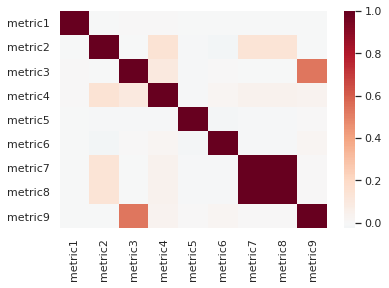

In [20]:
# Data Visualization

df_att = df[['metric1', 'metric2', 'metric3', 'metric4', 'metric5', 
             'metric6', 'metric7', 'metric8', 'metric9']]
corr_pearson = df_att.corr() 

import seaborn as sns
sns.set()
sns.heatmap(corr_pearson, center = 0, cmap = 'RdBu_r')

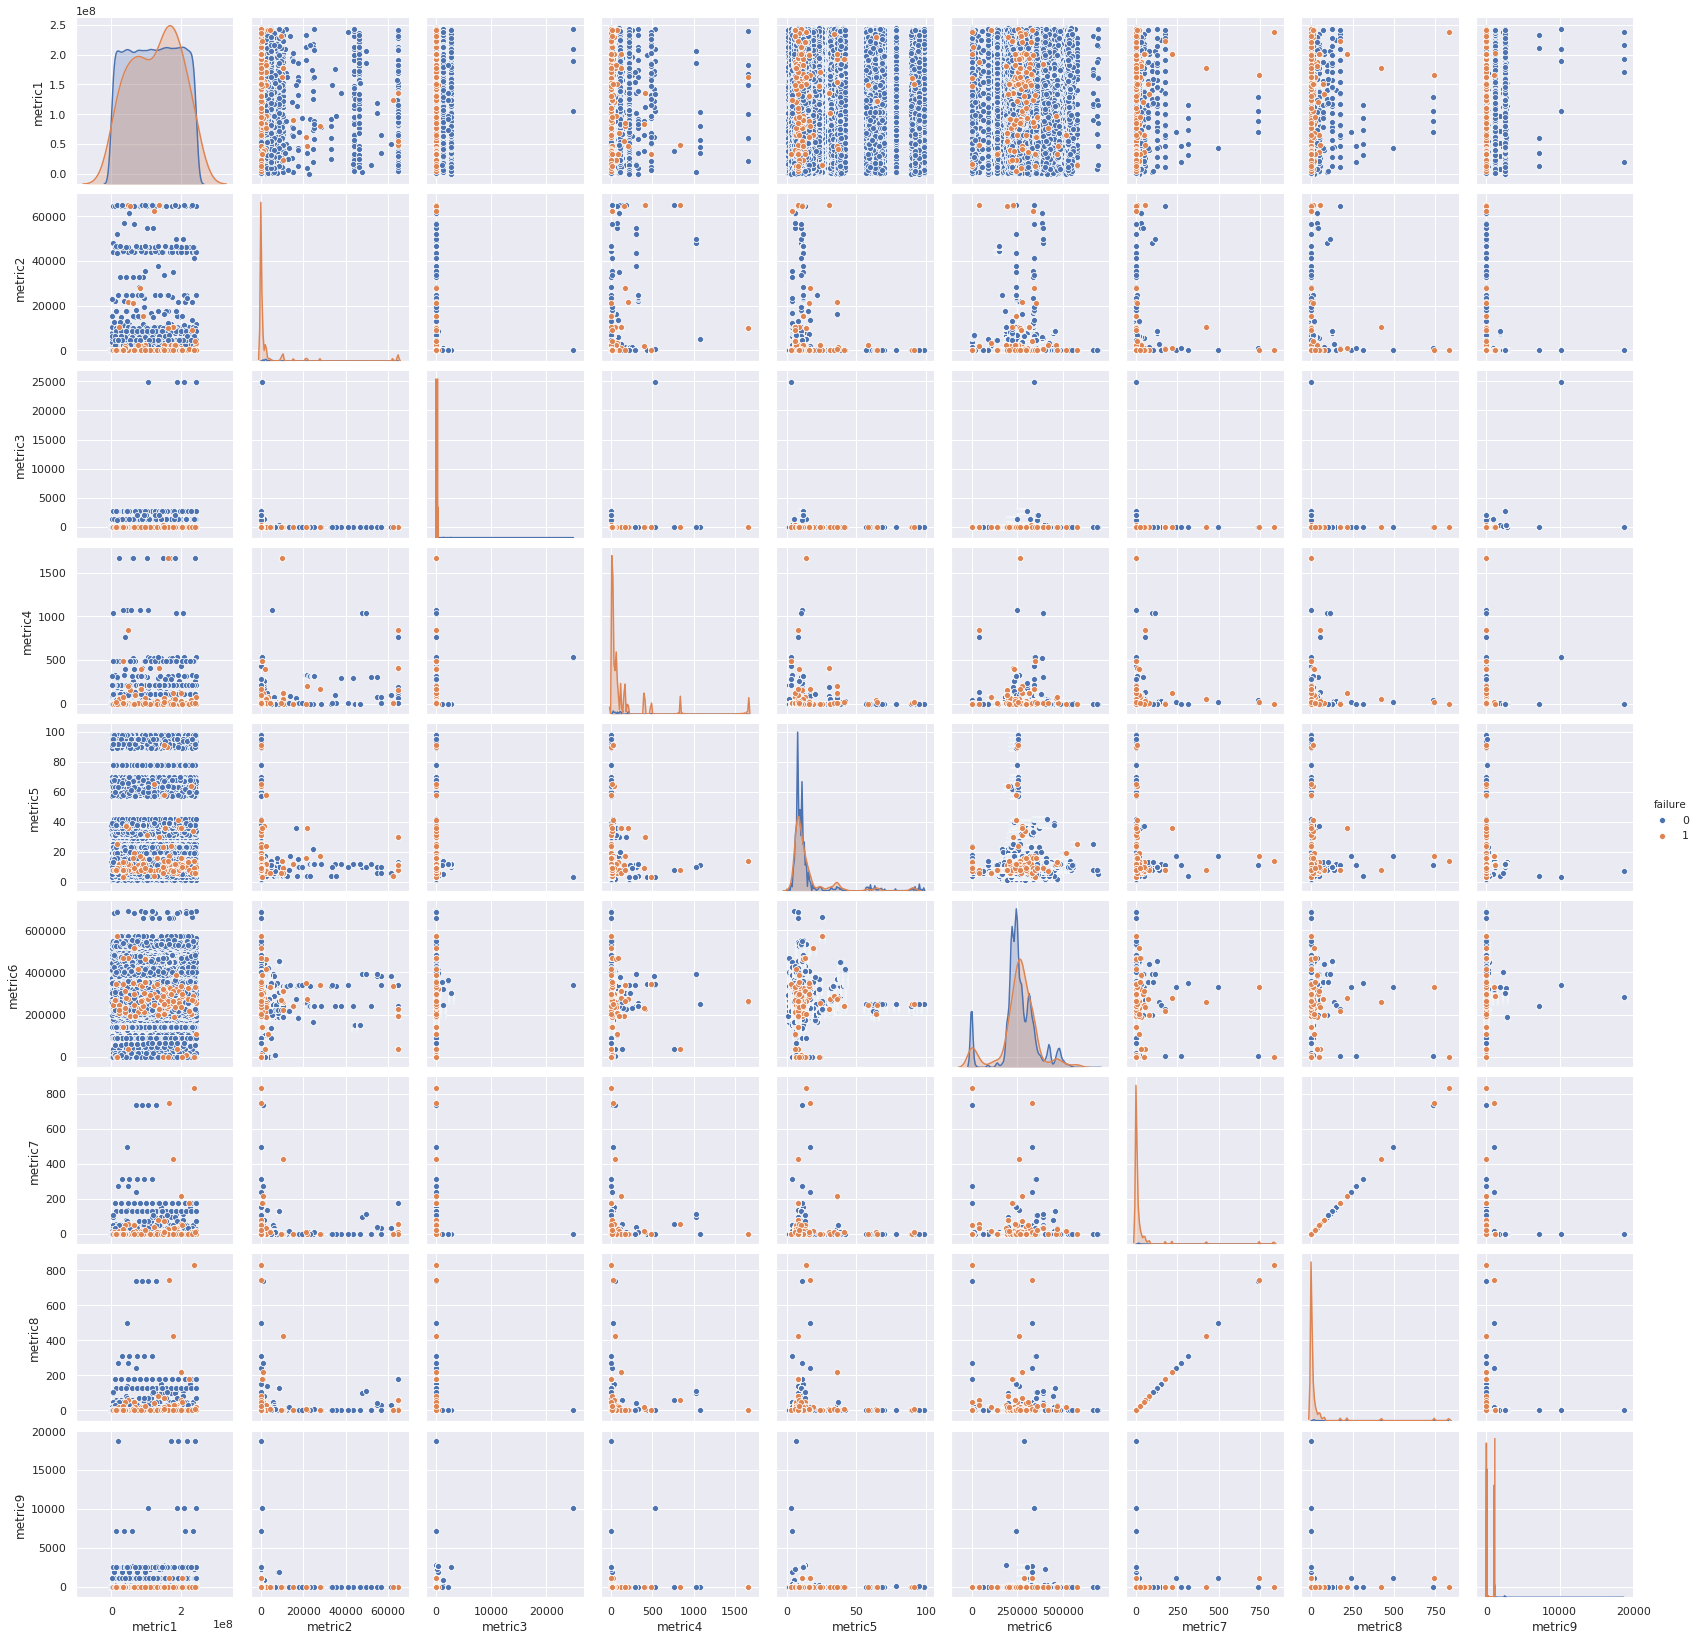

In [21]:
# pair plot to see feature correlations with each other

import seaborn as sns
sns.pairplot(df,hue='failure')

In [0]:
# It is obvious that metric7 and metric8 is highly linear related or equal to each other

# EDA Summary:
- given dataset is clean, no missing values.
- data set is imbalanced, as the failure class is about 0.1% of unfailure class. So we can use oversampling approach to deal with the imbalanced dataset.
- Some attributes have limited number of distictive values, very sparse, indicating that they are likely to be categorical variable, such as attibute 3, 5,7,9.
- Metric7 and 8 seems like exactly same to each other, we can drop one of them

# Data pre processing

In [0]:
# since metric7 and metric8 perfectly correlated. dropping metric8 to avoid perfect collineraity

In [0]:
df = df.drop(['metric8'], axis=1)

In [25]:
df.head()

,date,device,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric9
0,1/1/15,S1F01085,0,215630672,56,0,52,6,407438,0,7
1,1/1/15,S1F0166B,0,61370680,0,3,0,6,403174,0,0
2,1/1/15,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0
3,1/1/15,S1F01JE0,0,79694024,0,0,0,6,410186,0,0
4,1/1/15,S1F01R2B,0,135970480,0,0,0,15,313173,0,3


In [0]:
# Same device is used multiple times. A DataFrame is created which has the count of all the devices, so this information can be used later 
# when the data in consolidated

In [27]:
df[df['device'] == 'Z1F0QLC1'].head()

,date,device,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric9
1076,1/1/15,Z1F0QLC1,0,71350416,0,0,0,7,198020,0,0
2239,1/2/15,Z1F0QLC1,0,90497888,0,0,0,7,199378,0,0
3402,1/3/15,Z1F0QLC1,0,109075808,0,0,0,7,200777,0,0
4564,1/4/15,Z1F0QLC1,0,138358848,0,0,0,7,202115,0,0
5725,1/5/15,Z1F0QLC1,0,163297864,0,0,0,7,203438,0,0


In [0]:
# A new DataFrame is created that has device count and then the column is renamed

In [29]:
df_device_count = pd.DataFrame(df.groupby('device')['device'].count())
df_device_count.head()

,device
device,
S1F01085,6
S1F013BB,6
S1F0166B,6
S1F01E6Y,48
S1F01JE0,6


In [30]:
df_device_count.rename(columns={'device':'device_count'}, inplace = True) # rename to device count
df_device_count.head()

,device_count
device,
S1F01085,6
S1F013BB,6
S1F0166B,6
S1F01E6Y,48
S1F01JE0,6


In [31]:
# Group by
df.nunique()

date          304
device       1169
failure         2
metric1    123877
metric2       558
metric3        47
metric4       115
metric5        60
metric6     44838
metric7        28
metric9        65
dtype: int64

In [0]:
# There are different ways to groupby. There are 124,493 rows, doing Groupby on date will bring down the dataset to 304. 
# And doing groupby on device will bring down the dataset to 1,169 unique values. 
# Groupby is done on the device, because doing groupby on date will make the dataset too small. 
# Doing groupby on devices will consolidate the date into 1,169 rows which is a better number than date for training. 
# If the dataset is done on device, then it can be analyzed how many times a device was used and not too much information is lost.

In [33]:
new_data = df.groupby('device').max()
new_data.head()

,date,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric9
device,,,,,,,,,,
S1F01085,1/6/15,0,215630672,56,0,52,6,409404,0,7
S1F013BB,5/9/15,0,243346080,0,0,0,5,689161,0,0
S1F0166B,1/6/15,0,224339296,0,3,0,6,404786,0,0
S1F01E6Y,2/9/15,0,240257968,0,0,0,12,259491,0,0
S1F01JE0,1/6/15,0,235562856,0,0,0,6,412151,0,0


In [0]:
# DataFrame that was created earlier for device count will be joined together with the groupby DataFrame, so there is a total count that device was used.
# Count can also be done with groupby, but doing count through groupby will give the count for all the features, which will increase the number of features 
# that are not needed, so a separate DataFrame of device count is created and then joined together with the groupby DataFrame.


In [34]:
new_data = new_data.join(df_device_count, on ='device')
new_data.head()

,date,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric9,device_count
device,,,,,,,,,,,
S1F01085,1/6/15,0,215630672,56,0,52,6,409404,0,7,6
S1F013BB,5/9/15,0,243346080,0,0,0,5,689161,0,0,6
S1F0166B,1/6/15,0,224339296,0,3,0,6,404786,0,0,6
S1F01E6Y,2/9/15,0,240257968,0,0,0,12,259491,0,0,48
S1F01JE0,1/6/15,0,235562856,0,0,0,6,412151,0,0,6


In [0]:
# Date in this DataFrame appears as a string. Month is extracted from that date column.
# Datetime module can be used to extract other features from the date column, but for this project lambda is used to simply extract month 
# since all the dates are for the same year.

In [36]:
new_data.date = list(map(lambda x:x[5:7], new_data.date ))
new_data.head()

,date,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric9,device_count
device,,,,,,,,,,,
S1F01085,5,0,215630672,56,0,52,6,409404,0,7,6
S1F013BB,5,0,243346080,0,0,0,5,689161,0,0,6
S1F0166B,5,0,224339296,0,3,0,6,404786,0,0,6
S1F01E6Y,5,0,240257968,0,0,0,12,259491,0,0,48
S1F01JE0,5,0,235562856,0,0,0,6,412151,0,0,6


In [37]:
# Date column is renamed to month.
new_data.rename(columns={'date':'month'}, inplace = True)
new_data.head()

,month,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric9,device_count
device,,,,,,,,,,,
S1F01085,5,0,215630672,56,0,52,6,409404,0,7,6
S1F013BB,5,0,243346080,0,0,0,5,689161,0,0,6
S1F0166B,5,0,224339296,0,3,0,6,404786,0,0,6
S1F01E6Y,5,0,240257968,0,0,0,12,259491,0,0,48
S1F01JE0,5,0,235562856,0,0,0,6,412151,0,0,6


In [38]:
new_data.device_count.max()

304

In [0]:
# Below are all the devices that were used 304 times, so these devices were not only used in the month of November, 
# but these devices were also used in other months.

In [40]:
new_data[new_data.device_count == 304].head()

,month,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric9,device_count
device,,,,,,,,,,,
S1F0E9EP,5,0,242890792,0,0,12,11,353337,0,0,304
S1F0EGMT,5,0,244129416,0,0,13,11,347165,32,0,304
S1F0FGBQ,5,0,243458728,0,0,0,12,309988,0,0,304
S1F0FP0C,5,0,243651936,0,0,0,12,356892,0,0,304
S1F0GCED,5,0,240061656,64792,0,7,11,341541,0,0,304


In [41]:
new_data.nunique()

month              2
failure            2
metric1         1169
metric2          118
metric3           44
metric4           67
metric5           58
metric6         1135
metric7           23
metric9           63
device_count     142
dtype: int64

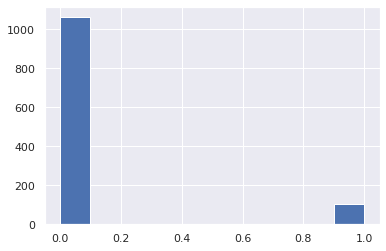

In [42]:
# Visualizing failure

new_data.failure.hist()

In [43]:
print(new_data.failure[new_data.failure == 0].count())
print(new_data.failure[new_data.failure == 1].count())

1063
106


In [0]:
# The above histogram and value counts above show that more devices have a value of 0 and fewer devices have a value of 1.
#  What that means is that more devices never failed and only a handful of devices failed. This dataset is highly imbalanced because 90% of the devices 
# have a value of 0 and only 10% have a value of 1. This will make it hard to train a good model because on a dataset like this model will get trained 
# to mostly predict 0, which is that the device never fails and the model will have a strong bias towards 0.

In [0]:
# Creating a model - All the features are assigned to x and failure the target variable is assigned to y.

In [0]:
y = new_data['failure']
del new_data['failure']
x = new_data

In [0]:
# choosing the training and testing data set 

X_train, X_validation, y_train, y_validation = train_test_split(x, y, test_size=0.3, random_state=42)

In [48]:
print(y_validation[y_validation==1].count())
print(y_validation[y_validation==0].count())

32
319


In [49]:
y_train.value_counts()

0    744
1     74
Name: failure, dtype: int64

In [50]:
y_validation.value_counts()

0    319
1     32
Name: failure, dtype: int64

# Oversampling method

In [0]:
from imblearn.over_sampling import SMOTE
smt = SMOTE(random_state=0, k_neighbors = 3)
x_resampled_train, y_resampled_train = smt.fit_sample(X_train, y_train)

In [52]:
print((y_resampled_train==0).sum())
print((y_resampled_train==1).sum())

744
744


# Model building

In [0]:
# Import required Algorithms..

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.ensemble import VotingClassifier

In [0]:
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()
gb = GradientBoostingClassifier()
lr = LogisticRegression()
kn = KNeighborsClassifier(n_neighbors = 3)

vote = VotingClassifier(estimators = [('d1', dt),('r1', rf),('g1',gb)], weights=[1,2,2])

In [0]:
# Fit the data

dtr = dt.fit(x_resampled_train, y_resampled_train)
rfr = rf.fit(x_resampled_train, y_resampled_train)
gbr = gb.fit(x_resampled_train, y_resampled_train)
lrr = lr.fit(x_resampled_train, y_resampled_train)
knn = kn.fit(x_resampled_train, y_resampled_train)

votec = vote.fit(x_resampled_train, y_resampled_train)

In [56]:
# Print Matrices

print("Decision Tree training score", dtr.score(x_resampled_train, y_resampled_train))
print("Random Forest training score", rfr.score(x_resampled_train, y_resampled_train))
print("Gradient Boosting training score", gbr.score(x_resampled_train, y_resampled_train))
print("Logistic Regression training score", lrr.score(x_resampled_train, y_resampled_train))
print("KNeighbors training score", knn.score(x_resampled_train, y_resampled_train))

print("Voting Classifier training score", votec.score(x_resampled_train, y_resampled_train))

Decision Tree training score 1.0
Random Forest training score 1.0
Gradient Boosting training score 0.9926075268817204
Logistic Regression training score 0.6189516129032258
KNeighbors training score 0.883736559139785
Voting Classifier training score 1.0


In [57]:
print("Decision Tree test score", dtr.score(X_validation, y_validation))
print("Random Forest test score", rfr.score(X_validation, y_validation))
print("Gradient Boosting test score", gbr.score(X_validation, y_validation))
print("Logistic Regression test score", lrr.score(X_validation, y_validation))
print("KNeighbors test score", knn.score(X_validation, y_validation))

print("Voting Classifier test score", votec.score(X_validation, y_validation))

Decision Tree test score 0.9230769230769231
Random Forest test score 0.9458689458689459
Gradient Boosting test score 0.9515669515669516
Logistic Regression test score 0.7635327635327636
KNeighbors test score 0.6780626780626781
Voting Classifier test score 0.9487179487179487


In [58]:
print(y_validation[y_validation==1].count())
print(y_validation[y_validation==0].count())

32
319


In [0]:
# y_validation shown above is the original testing data set that was not over-sampled and has imbalanced classes for 0 and 1. 
# There are 319 un-failed devices and only 32 failed devices.

In [0]:
# Accuracy score will examine how well the model would do if the classes are imbalanced

In [0]:
from sklearn.metrics import accuracy_score

d_predict = dt.predict(X_validation)
r_predict = rf.predict(X_validation)
g_predict = gb.predict(X_validation)
l_predict = lr.predict(X_validation)
k_predict = kn.predict(X_validation)

v_predict = vote.predict(X_validation)

In [62]:
print("Decision tree:", accuracy_score(y_validation, d_predict))
print("Random Forest:", accuracy_score(y_validation, r_predict))
print("Gradient Boosting:", accuracy_score(y_validation, g_predict))
print("Logistic Regression:", accuracy_score(y_validation, l_predict))
print("KNeighbors:", accuracy_score(y_validation, k_predict))

print("Voting Classifier:", accuracy_score(y_validation, v_predict))

Decision tree: 0.9230769230769231
Random Forest: 0.9458689458689459
Gradient Boosting: 0.9515669515669516
Logistic Regression: 0.7635327635327636
KNeighbors: 0.6780626780626781
Voting Classifier: 0.9487179487179487


Decision tree, Random Forest, Gradient Boosting, and Voting Classifier performed really well. 
These models were able to achieve over 90% accuracy even when the testing dataset is imbalanced.

In [0]:
# Precision and Recall - Precision and recall is related to confusion matrix(type I and type II error).
# Precision is relevant items divided by total items. Precision calculates how many times was something correctly labelled or mislabelled.
# Recall is the relevant items divided by relevant. Recall calculates how many times was the correctly labelled item missed.


In [0]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [64]:
print("Precision for Decision tree:", precision_score(y_validation, d_predict))
print("Recall for Decision tree:", recall_score(y_validation, d_predict))
print("\nPrecision for Random Forest:", precision_score(y_validation, r_predict))
print("Recall for Random Forest:", recall_score(y_validation, r_predict))
print("\nPrecision for Gradient Boosting:", precision_score(y_validation, g_predict))
print("Recall for Gradient Boosting:", recall_score(y_validation, g_predict))
print("\nPrecision for Logistic Regression:", precision_score(y_validation, l_predict))
print("Recall for Logistic Regression:", recall_score(y_validation, l_predict))
print("\nPrecision for KNeighbors:", precision_score(y_validation, k_predict))
print("Recall for KNeighbors:", recall_score(y_validation, k_predict))

print("\nPrecision for Voting Classifier:", precision_score(y_validation, v_predict))
print("Recall for Voting Classifier:", recall_score(y_validation, v_predict))

Precision for Decision tree: 0.5675675675675675
Recall for Decision tree: 0.65625

Precision for Random Forest: 0.7407407407407407
Recall for Random Forest: 0.625

Precision for Gradient Boosting: 0.7272727272727273
Recall for Gradient Boosting: 0.75

Precision for Logistic Regression: 0.1506849315068493
Recall for Logistic Regression: 0.34375

Precision for KNeighbors: 0.08247422680412371
Recall for KNeighbors: 0.25

Precision for Voting Classifier: 0.7333333333333333
Recall for Voting Classifier: 0.6875


In [0]:
# Precision doesn't look at how many times was the correctly labelled item missed. And recall disregards how many items were incorrectly labelled, 
# which is why a model can have high precision, but low recall, or low recall and high precision. Depending on the domain, business objective and 
# project precision might be preferred over recall and vice versa. But if the goal is to make the best model and there is no emphasis on precision 
# and recall, F1 score can be used. F1 score can be calculated by the following equation: 2*(product of precision and recall) divided by 
# (sum of precision and recall).

# Classification report - F1 score can be manually calculated, but classification report can get the F1 score without having to calculate it manually.
# Classification report also shows precision, recall, which can replace the precision and recall scores calculated above.


Precision, recall and accuracy score for Logistic Regression and KNeighbors are low which is why they are not used for classification report

In [66]:
from sklearn.metrics import classification_report

print("Decision Tree:\n",classification_report(y_validation, d_predict))
print("\nRandom Forest:\n",classification_report(y_validation, r_predict))
print("\nGradient Boostingn:\n",classification_report(y_validation, g_predict))
print("\nVoting Classifier:\n",classification_report(y_validation, v_predict))

Decision Tree:
               precision    recall  f1-score   support

           0       0.96      0.95      0.96       319
           1       0.57      0.66      0.61        32

    accuracy                           0.92       351
   macro avg       0.77      0.80      0.78       351
weighted avg       0.93      0.92      0.93       351


Random Forest:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97       319
           1       0.74      0.62      0.68        32

    accuracy                           0.95       351
   macro avg       0.85      0.80      0.82       351
weighted avg       0.94      0.95      0.94       351


Gradient Boostingn:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97       319
           1       0.73      0.75      0.74        32

    accuracy                           0.95       351
   macro avg       0.85      0.86      0.86       351
weighted avg       

# Conclusion:

- The above classification report gives scores for precision, recall, and f1. And these scores will change when the model is trained and tested again. 
But looking at the above scores, **Gradient boosting** would be a good model to use on unknown dataset because gradient boosting can identify minority class 
better than other models and has higher f1 score for minority class.

- Cross Validation scores are not computed for over-sampling because the over-sampling was only done on the training dataset and running cross validation will show higher f1 scores which are misleading. And x_test and y_test cannot be used in cross validation because there is imbalanced dataset, 
that will give lower f1 score.



There are some improvements we can consider in next step:
- Check the featrue importance and drop the nonsignificant feature from model
- Use GridSearch to find the best combination of parameters in the model
- Try other over-sampling approaches and see if it will improve the model performance
- Use the CrossValidation to avoid the model overfitting
- We can try neural network solution that could turn out to be the best solution when optimized